## Machine Learning : Theory and Applications (2025/26)
Simona Cocco & Vito Dichio

# Tutorial 1 (SOLUTION)

**Topic:** Poisson processes, Bayesian inference, and spike trains  

**Goals:**  
1) simulate Poisson spike trains;  
2) compute the posterior for rate under a simple prior;  
3) compare model vs data.

**Bibliography:**
From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology (1st Edition), by Simona Cocco, Rémi Monasson, Francesco Zamponi -- 2022

### Setup

In [1]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np 

# Set a seed for reproducibility
SEED = 11092025
rng = np.random.default_rng(SEED)

## Part A — Simulated data
In a homogeneous Poisson process with rate $\theta$ (spikes/s), the spike count in a window of length $T$ is
$$
\Pr[X=k] = \frac{(\theta T)^k e^{-\theta T}}{k!}, \quad k=0,1,2,\dots
$$

**Question A1:** Simulate a Poisson process with rate $\theta=0.5$, and different observation times $T=10, 100, 1000$. Plot the spike times for each $T$.

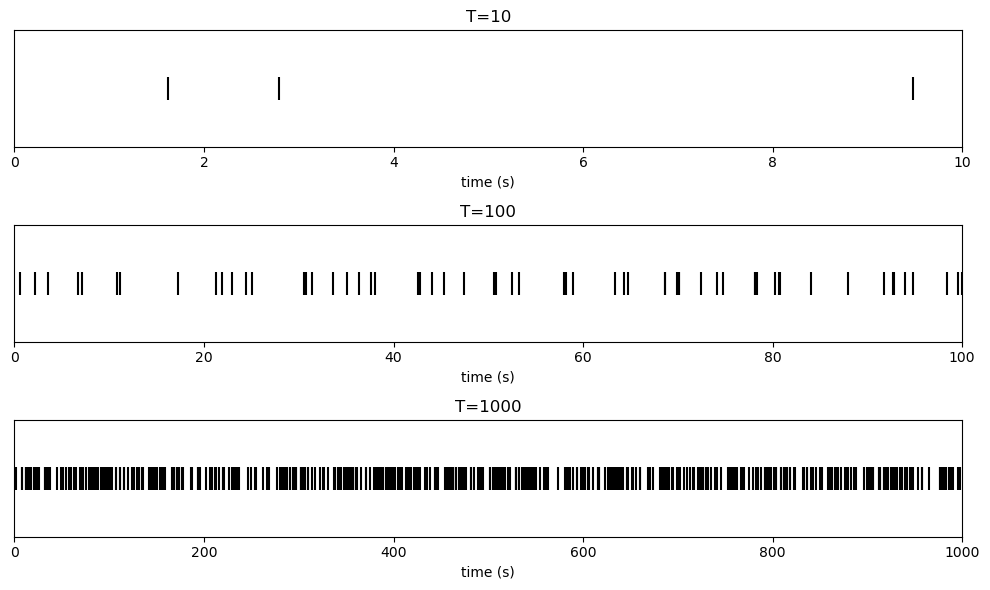

In [3]:
def simulate_poisson(rate, T, rng):
    """Simulate spike times for a Poisson process with given rate and duration T."""
    
    # Step 1: sample the number of spikes
    # Counts in [0,T] follow Poisson(rate * T)
    y = rng.poisson(rate * T)
    
    # Step 2: sample spike times uniformly in [0,T]
    # Given y spikes, their times are i.i.d. uniform
    spike_times = rng.uniform(0, T, size=y)
    
    # Step 3: sort spike times so they appear in chronological order
    return np.sort(spike_times)


def plot_raster(spikes, T, title=None):
    plt.vlines(spikes, -0.2, 0.2, color='black')
    plt.xlim(0, T)
    plt.ylim(-1, 1)
    plt.xlabel("time (s)")
    if title:
        plt.title(title)

# Question 1
rate = 0.5
Ts = [10, 100, 1000]
samples = [simulate_poisson(rate, T, rng) for T in Ts]

# Create a new figure with specified size
plt.figure(figsize=(10, 6))
# Loop over each observation window T and its corresponding spike times
for i, (T, spikes) in enumerate(zip(Ts, samples), 1):
    # Create a subplot for each T (stacked vertically)
    plt.subplot(len(Ts), 1, i)
    # Plot the spike raster for the current T
    plot_raster(spikes, T, title=f"T={T}")
    # Remove y-axis ticks and labels for clarity
    plt.tick_params(left=False, labelleft=False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



**Question A2.** From the observed counts (not spike times), compute the posterior distribution of the rate parameter $\theta$.  
Assume a uniform prior on $\theta>0$.

## Derivation of the posterior distribution

We observe a **homogeneous Poisson process** with constant rate $\theta$ (spikes/s) over duration $T$.  

#### Setup
Let's calculate the posterior distribution of the rate parameter $\theta$ given observed spike counts by applying Bayes' theorem.
$$
P(\theta \mid y) = \frac{P(y \mid \theta) P(\theta)}{P(y)}.
$$

#### Likelihood (Poisson)
Let $Y$ be the spike count in $[0,T]$. By definition of a Poisson process,

$$
P(Y=y \mid \theta) = \frac{(\theta T)^y e^{-\theta T}}{y!}, \qquad y=0,1,2,\dots
$$

#### Prior
Before looking at the data, every positive rate $\theta$ is equally likely. We use the (improper) uniform prior on the nonnegative reals: $P(\theta)\propto 1$ for $\theta \ge 0$.  

#### Propobability of the evidence
The evidence $P(y)$ is a normalizing constant ensuring the posterior integrates to 1.

$$
P(y) = \int_0^\infty P(y|\theta)P(\theta)\mathrm{d}\theta = \int_0^\infty \frac{(\theta T)^y e^{-\theta T}}{y!} \mathrm{d}\theta = \frac{1}{T} \frac{1}{y!} \int_0^\infty x^y e^{-x} \mathrm{d}x = \frac{1}{T} \frac{\Gamma(y+1)}{y!}  = \frac{1}{T},
$$
where the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function) was used:
$$
\Gamma(x) \equiv \int_0^\infty t^{x-1}\exp(-t) \mathrm dt
$$
and the fact that $\Gamma(n+1) = n!$ for $n \in \mathbb{N}$.

#### Posterior 
Putting it all together, the posterior reads:

$$
P(\theta \mid y) = \frac{T^{y+1}}{\Gamma(y+1)} \, \theta^{y} e^{-T\theta}, \quad \theta \ge 0.
$$

-----

**Comments**
1. This was a highly uncommon case, since the probability of the evidence $P(y)$ could be computed analytically. In general, this integral is often intractable.
2. The posterior is in fact a [**Gamma distribution**](https://en.wikipedia.org/wiki/Gamma_distribution), with probability density $$ f(x; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}\, x^{\alpha-1} e^{-\beta x}, \quad x \ge 0, $$where $\alpha$ is the **shape** parameter and $\beta$ the **rate** (inverse of the scale).
   In our case, the posterior has  $\alpha = y+1,\ \ \beta = T.$ This is available in the scipy library as ['scipy.stats.gamma'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) .

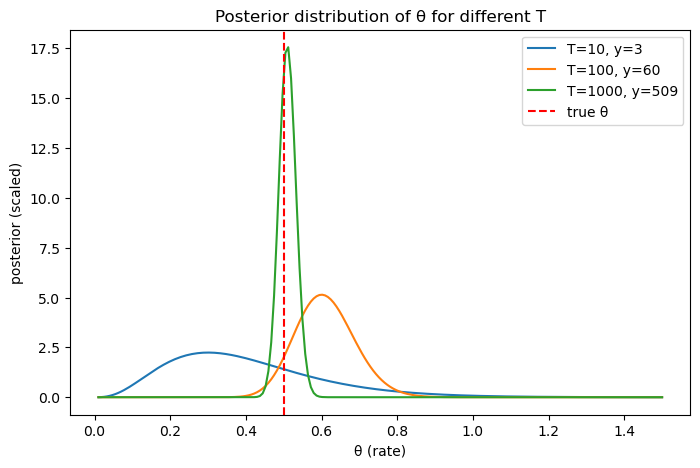

In [11]:
# --- Numerical approach ---
# We compute the exact posterior, and plot it for different T.

from scipy.special import loggamma

def log_likelihood(theta, y, T):
    """Log-likelihood of observing y spikes in [0,T] for rate θ."""
    # Using log form is numerically stable:
    # - avoids overflow in (θT)^y and factorial(y)
    # - avoids underflow in exp(-θT)
    # - loggamma(y+1) safely computes log(y!) for large y
    return y * np.log(theta * T) - (theta * T) - loggamma(y + 1)


def posterior(theta, y, T):
    """Posterior distribution for rate theta with uniform prior."""
    return T*np.exp(log_likelihood(theta, y, T))

# Alternatively
def posterior_scipy(theta, y, T):
    """Posterior distribution using scipy's gamma pdf."""
    from scipy.stats import gamma
    alpha = y + 1    # shape
    beta = T         # rate
    scale = 1 / beta # scipy expects scale = 1/rate
    return gamma.pdf(theta, a=alpha, scale=scale)

#------------------------------------------------#

# Example: posterior for the simulations in Question 1

# Create a grid of theta values to evaluate the posterior
thetas = np.linspace(0.01, 1.5, 200)

plt.figure(figsize=(8, 5))

for T, spikes in zip(Ts, samples):
    y = len(spikes)                         # Number of observed spikes (count)
    post = posterior(thetas, y, T) # Compute the posterior for each theta
    plt.plot(thetas, post, label=f"T={T}, y={y}")  # Plot the posterior curve

# Draw a vertical line at the true rate for reference
plt.axvline(rate, color="red", ls="--", label="true θ")

# Label axes and add title/legend
plt.xlabel("θ (rate)")
plt.ylabel("posterior (scaled)")
plt.title("Posterior distribution of θ for different T")
plt.legend()
plt.show()


**Question A3.** Compute **(i)** the posterior mean estimator, **(ii)** the Maximum Likelihood Estimator (MLE), and **(iii)** the estimator variance.

### MLE and posterior mean, variance

#### **Maximum-likelihood estimator**
According to the maximum likelihood principle, the best estimate of $\theta$ is the value that maximizes the likelihood $P(y\mid \theta)$ - here, a Poisson distribution:

$$
\hat\theta_{\text{MLE}} \;=\; \arg\max_\theta \big[ \frac{(\theta T)^y e^{-\theta T}}{y!}\big] \;=\;  \arg\max_\theta \big[\theta^y e^{-\theta T}\big] \;=\; \frac{y}{T}.
$$

Note that in order to compute the argmax of a function, we can forget about multiplicative constants (here, $T^y/y!$ ) that do not depend on $\theta$.

*Proof*.
$$
\frac{d}{d\theta}\big[\theta^y e^{-\theta T}\big]=0 \quad \Rightarrow (y-T\theta)\theta^{y-1}e^{-\theta T}=0 \quad \Rightarrow \quad \theta=\frac{y}{T}.
$$

#### Posterior mean.
$$
\langle \theta \rangle \;=\; \int_0^\infty \theta\, P(\theta\mid y)\, d\theta \;=\; \int_0^\infty \frac{(\theta T)^{y+1}}{\Gamma(y+1)} \,  e^{-T\theta} d\theta\;=\; \frac{1}{T}\int_0^\infty \frac{x^{y+1}}{\Gamma(y+1)} \,  e^{-x} dx\;=\;  \frac{\Gamma(y+2)}{\Gamma(y+1)}\frac{1}{T} \;=\; \frac{y+1}{T}.
$$ 
#### Posterior variance
$$
\mathrm{Var}[\theta\mid y] \;=\; \langle \theta^2 \rangle - \langle \theta \rangle^2 
\;=\; \frac{y+1}{T^2}
\;=\; \frac{\langle \theta \rangle}{T},
$$

where
$$
\langle \theta^2 \rangle \;=\;  \int_0^\infty \frac{T^{y+1}}{\Gamma(y+1)} \, \theta^{y+2} e^{-T\theta} d\theta\;=\;  \frac{(y+2)(y+1)}{T^2}.
$$

In [5]:
def estimators_for_count(y, T):
    """
    Given count y over duration T:
      - Posterior: Gamma(shape = y+1, rate = T)  → scale = 1/T
      - Posterior mean: (y+1)/T
      - MLE: y/T
      - Posterior variance: (y+1)/T^2
    """
    theta_mean = (y + 1) / T
    theta_mle  = y / T
    var_theta  = (y + 1) / (T**2)
    return theta_mean, theta_mle, var_theta

print("Estimators (posterior mean, MLE) and posterior variance")
print("-" * 65)
for T, spikes in zip(Ts, samples):
    y = len(spikes)
    theta_mean, theta_mle, var_theta = estimators_for_count(y, T)

    print(f"T={T:>5} | y={y:>4} | "
          f"mean={(theta_mean):.2e} | MLE={(theta_mle):.2e} | var={(var_theta):.2e} ")

Estimators (posterior mean, MLE) and posterior variance
-----------------------------------------------------------------
T=   10 | y=   7 | mean=8.00e-01 | MLE=7.00e-01 | var=8.00e-02 
T=  100 | y=  63 | mean=6.40e-01 | MLE=6.30e-01 | var=6.40e-03 
T= 1000 | y= 511 | mean=5.12e-01 | MLE=5.11e-01 | var=5.12e-04 
